# MobileNet v2
### Reference: 
1. [MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://arxiv.org/abs/1801.04381)

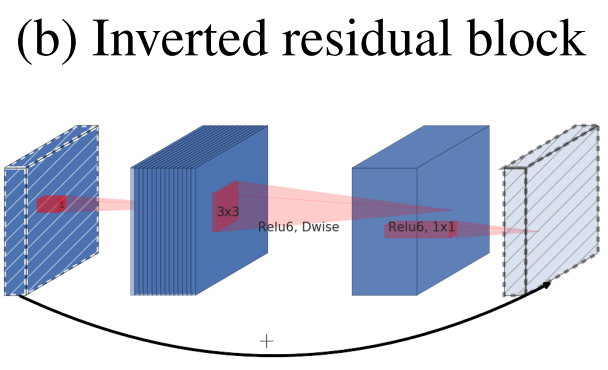

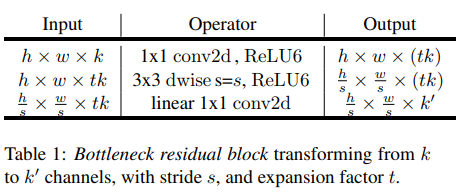

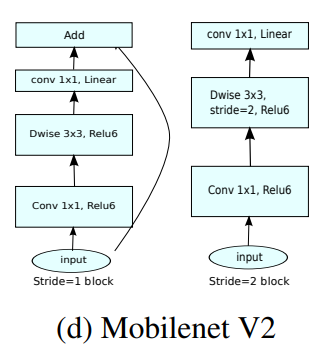

In [29]:
from tensorflow.keras import layers as KL
from tensorflow.keras import models as KM

In [89]:
def MBConv_s1(X, Cout: int, t: int=6):
  '''Args:
      X (tf.Tensor): Input tensor
      Cout (int): Output channel. I know it is decied by the neural search network,
                  but I don't understand the intuition of its stochastic depth.
      t (int): Expansion factor. It's between 5-10.
               The researchers decided that 6 is the best for the study.
    Return:
      tf.Tensor
  '''
  Cin = X.shape[-1]
  expand = Cin * t
  # Expand layer
  x = KL.Conv2D(filters=expand, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
  x = KL.BatchNormalization(momentum=0.99)(x)
  x = KL.ReLU(max_value=6)(x)
  # Dwise layer
  x = KL.DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  x = KL.BatchNormalization(momentum=0.99)(x)
  x = KL.ReLU(max_value=6)(x)
  if Cin != Cout:
    # Squeeze layer
    x = KL.Conv2D(filters=Cout, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    add = KL.Conv2D(filters=Cout, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    # Residual layer
    add = KL.add([add, x])
    return add
  # Squeeze layer
  x = KL.Conv2D(filters=Cin, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  # Residual layer
  add = KL.add([X, x])
  return add

In [95]:
def MBConv_s2(X, Cout, t: int=6):
  '''Args:
      X (tf.Tensor): Input tensor
      Cout (int): Output channel. I know it is decied by the neural search network,
                  but I don't understand the intuition of its stochastic depth.
      t (int): Expansion factor. It's between 5-10.
               The researchers decided that 6 is the best for the study.
    Return:
      tf.Tensor
  '''
  Cin = X.shape[-1]
  expand = Cin * t
  # Expand layer
  x = KL.Conv2D(filters=expand, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
  x = KL.BatchNormalization(momentum=0.99)(x)
  x = KL.ReLU(max_value=6)(x)
  # Dwise layer
  x = KL.DepthwiseConv2D(kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
  x = KL.BatchNormalization(momentum=0.99)(x)
  x = KL.ReLU(max_value=6)(x)
  # Squeeze layer
  x = KL.Conv2D(filters=Cout, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  x = KL.BatchNormalization(momentum=0.99)(x)
  return x

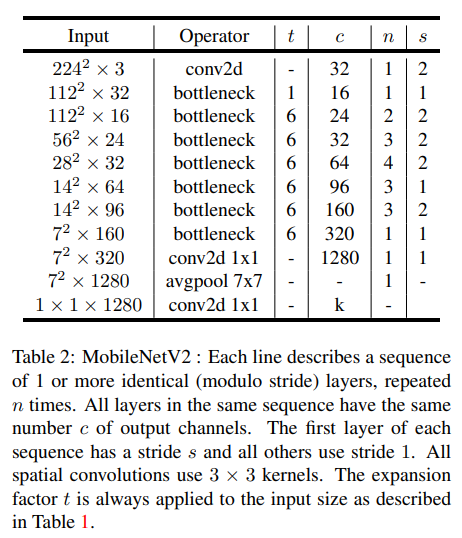

In [96]:
def model():
  inputs = KL.Input(shape=(224, 224, 3))
  # Stage 1
  x = KL.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same')(inputs)
  # STage 2
  x = MBConv_s1(x, t=1, Cout=16)
  # Stage 3
  x = MBConv_s2(x, t=6, Cout=24)
  x = MBConv_s1(x, t=6, Cout=24)
  # Stage 4
  x = MBConv_s2(x, t=6, Cout=32)
  for _ in range(2):
    x = MBConv_s1(x, t=6, Cout=32)
  # Stage 5
  x = MBConv_s2(x, t=6, Cout=64)
  for _ in range(3):
    x = MBConv_s1(x, t=6, Cout=64)
  # Stage 6
  x = MBConv_s2(x, t=6, Cout=96)
  for _ in range(2):
    x = MBConv_s1(x, t=6, Cout=96)
  # # Stage 7
  x = MBConv_s1(x, t=6, Cout=160)
  # # Stage 8
  x = MBConv_s1(x, t=6, Cout=320)
  # Stage 9
  x = KL.Conv2D(filters=1280, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  # Network head
  x = KL.AveragePooling2D(pool_size=(7, 7), padding='valid')(x)
  outputs = KL.Conv2D(filters=1280, kernel_size=(1, 1), strides=(1, 1))(x)

  model = KM.Model(inputs=inputs, outputs=outputs)
  model.summary()

In [97]:
model()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_558 (Conv2D)             (None, 112, 112, 32) 896         input_28[0][0]                   
__________________________________________________________________________________________________
conv2d_559 (Conv2D)             (None, 112, 112, 32) 1056        conv2d_558[0][0]                 
__________________________________________________________________________________________________
batch_normalization_663 (BatchN (None, 112, 112, 32) 128         conv2d_559[0][0]                 
___________________________________________________________________________________________